# Collaborative Filtering from Scratch

This notebook is used to demonstrate how to code and evaluate CF (Collaborative Filtering) using `sklearn`, `pandas`, `scipy`.

It is called "from scratch" as it does not use the `surprise` library.

## 1. Load libraries and data, inspect data, convert data as sparse

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import NearestNeighbors
import os
import matplotlib.pyplot as plt

Usage of these libraries:

1. `scipy.sparse`: for memory-efficient representation of ratings, vectorization of ratings manipulation.
    1. `coo` matrices: easiest representation, consisting of three numpy arrays row, col, data; manipulating the data array leads to manipulation of the underlying values.
    2. `csr` matrices: good for slicing rows; used for predicting ratings in item-based CF scenario.
    3. `csc` matrices: good for slicing columns; used for predicting item ratings in user-based CF scenario.
    4. `save_npz, load_npz` for checkpointing sparse matrices as files for fast loading.
2. `sklearn`'s libraries.
    1. `NearestNeighbors` from `sklearn.neighbors` for implementation of cosine similarity with baseline adjustments (whether adjust by mean or by a common number).
    2. `KFold, train_test_split` from `sklearn.model_selection`. This will be used in conjunction with evaluation metrics.
        1. Note: for `KFold, train_test_split`, this notebook implements splitting across "users" (not on ratings or items).

Specify where your `ratings.csv`, `books.csv` directories are.
1. `ratings.csv` is the main data that we run CF on.
2. `books.csv` is the data that we use for gaining more info on what are recommended by our recommendation system.

In [2]:
%%time
csv_dir = "/home/zebalgebra/School/DVA/The-Last-Book-Bender/Data/Raw/" # edit this line
ratings_all_df = pd.read_csv(
    os.path.join(csv_dir, "ratings.csv"),
    dtype={
        "user_id": "Int32", # 50k users, so this is needed
        "book_id": "Int16", # 10k books, so this is needed
        "rating": "Int8"    # ranging from 0-5, so this is enough
    }
)
ratings_all_df.head(3)

CPU times: user 6.73 s, sys: 244 ms, total: 6.97 s
Wall time: 6.99 s


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5


In [3]:
ratings_all_df.describe().transpose()[["count", "min", "max"]].astype("int32")

,count,min,max
user_id,5976479,1,53424
book_id,5976479,1,10000
rating,5976479,1,5


so the dataframe has 10k books, 50k users, 6M books, with ratings given between 1-5. The corresponding user-item matrix (with rows the books and columns the users) has density `5976479/(53424*10000)=1.11%`.

Using a sparse array for representing this dataframe can be nice. The dataframe is already a `coo` format; we directly build a `csc` matrix:

In [4]:
%%time
ratings_all_csc = sp.sparse.csc_matrix(
    (
        ratings_all_df["rating"], # data
        (ratings_all_df["book_id"], ratings_all_df["user_id"]) # (row, col)
    )
) # or csr. since we will slice on columns (users), csc is sensible

CPU times: user 195 ms, sys: 9.5 ms, total: 204 ms
Wall time: 203 ms


You can save this as an `npz` object using `save_npz`, and load it using `load_npz` (which is extremely fast).

## 2. Doing train test split for CV (on users)

Since we will be evaluating models by k-fold cross validation, and out splitting is done on users, we first see how we can utilize the `KFold` function and check the speed of column slicing `csc` matrices.

In [5]:
%%time
kf = KFold(n_splits=10, shuffle=True, random_state=6242) # change this for other CV options
user_ids = np.arange(53424 + 1) # the column range of our sparse matrix is 0-53424
for fold, (user_ids_train, user_ids_test) in enumerate(kf.split(user_ids)):
    print(f"Splitting for fold {fold} with train size {len(user_ids_train)}, test size {len(user_ids_test)}")
    true_size = (10000 + 1, 53424 + 1)
    ratings_train_csc = ratings_all_csc[:, user_ids_train]
    ratings_test_csc = ratings_all_csc[:, user_ids_test]

Splitting for fold 0 with train size 48082, test size 5343
Splitting for fold 1 with train size 48082, test size 5343
Splitting for fold 2 with train size 48082, test size 5343
Splitting for fold 3 with train size 48082, test size 5343
Splitting for fold 4 with train size 48082, test size 5343
Splitting for fold 5 with train size 48083, test size 5342
Splitting for fold 6 with train size 48083, test size 5342
Splitting for fold 7 with train size 48083, test size 5342
Splitting for fold 8 with train size 48083, test size 5342
Splitting for fold 9 with train size 48083, test size 5342
CPU times: user 62.7 ms, sys: 9.87 ms, total: 72.6 ms
Wall time: 71.9 ms


Side note: if we use `csr` matrices (try changing the `tocsc` to `tocsr` one of the previous block), the time needed for the above block will be 8-9x.

For demonstration purposes, we will be using the ninth fold (the last one) to show how set up CF. We will also make extensive use of the `user_ids_train` and `user_ids_test`, as converting from `csc` to `coo` will result in losing empty columns.

## 3.1. Collaborative Filtering - Shifting Ratings

The ratings are given from 1-5. We would guess that 3 = meh, 1 = terrible, 2 = bad, while 4, 5 indicates positive preference.

There are several CF metrics for similarities of users. Given two rating vectors $u,v$, with mean $\mu_u,\mu_v$ (taken over nonzero entries; some prefer to talk about non-null entries if zero ratings are present), and support $I_u,I_v$ (where $I_u$ is set of indices of $u$ with nonzero entries):

1. **Cosine similarity**: $(u\cdot v)/(\|u\|\|v\|)$
2. **Adjusted cosine similarity**: $(u'\cdot v')/(\|u'\|\|v'\|)$ where $u'_i=\begin{cases}u'_i-\mu_u&\text{if }i\in I_u\\0\end{cases}$; similarly for $v'$.
3. **Pearson correlation**: $(u''\cdot v'')/(\|u''\|\|v''\|)$ where $u''_i=\begin{cases}u'_i&\text{if }i\in I_u\cap I_v\\0\end{cases}$; similarly for $v''$.
4. **Pearson correlation with inverse user frequency**: $(u'''\cdot v''')/(\|u'''\|\|v'''\|)$ where $u'''_i=\sqrt{\log(m/m_i)}u''_i$, with $m$ being the number of users, $m_i$ being the number of users rating an item $i$.
5. Generalization of 2: take $u'_i=\begin{cases}f(u_i)&\text{if }i\in I_u\\0\end{cases}$ for some function $f$. Intuitively, $f(u_i)$ is a transformation of ratings that is only dependent on the value of ratings.
   * For this notebook, we will test with the function $f(u_i)=u_i-2.5$, which makes $1, 2$ negative, and $3, 4, 5$ positive. We call this an **Adjusted Baseline**

We will consider 1, 2, 5. We won't consider 3, 4, as it is a bit more complicated (`sklearn`'s `NearestNeighbors` will not be enough in this case (not supported for sparse inputs)).

To do 5., we can simply modify the underlying data array (these are ordinary `numpy` arrays):

In [6]:
%%time
ratings_train_csc_demo = ratings_train_csc.copy().astype(np.float64) # no references is shared for this copy method
mapping = np.array([0, -1.5, -0.5, 0.5, 1.5, 2.5])
ratings_train_csc_demo.data = mapping[ratings_train_csc.data.astype(np.int8)]
# alternatively, can use: ratings_train_csc_demo.data = ratings_train_csc.data - 2.5
ratings_train_csc.data - ratings_train_csc_demo.data

CPU times: user 37.4 ms, sys: 13.5 ms, total: 50.9 ms
Wall time: 49.9 ms


array([2.5, 2.5, 2.5, ..., 2.5, 2.5, 2.5])

To do 2., the process involves counting number of nonzero entries in each column, sum along column, divide:

In [7]:
%%time
ratings_train_csc_demo = ratings_train_csc.copy().astype(np.float64)
ratings_train_csc_demo_col = ratings_train_csc_demo.tocoo().col
col_sums = np.array(ratings_train_csc_demo.sum(axis=0)).flatten() # .sum(axis=0) gives np.matrix
col_nonzero_counts = np.array(ratings_train_csc_demo.minimum(1).sum(axis=0)).flatten()
ratings_train_csc_demo.data -= col_sums[ratings_train_csc_demo_col] / np.maximum(col_nonzero_counts[ratings_train_csc_demo_col], 0.5)
# 0.5 is to avoid DivisionByZero

CPU times: user 95.5 ms, sys: 39.9 ms, total: 135 ms
Wall time: 134 ms


These functions are abstracted as functions follows:

In [8]:
def dilate(X: sp.sparse.csc_matrix, amount: float) -> None:
    """
    deduct each nonempty entry of X by amount
    (this mutates the underlying csc matrix)
    for example, take a as baseline.
    """
    X.data -= np.float64(amount)

def value_remap(X: sp.sparse.csc_matrix, remapper: np.ndarray) -> None:
    """
    remap nonnull values of X based on remapper
    (if remapper[i]=j, value of i is remapped to j)
    since indexing array only take integers, this might give unexpected errors
    """
    X.data = remapper[X.data.astype(int)].astype(np.float64)

def make_mean_0(X: sp.sparse.csc_matrix) -> None:
    """
    make columns of a csc_matrix have zero mean
    (this function mutates the underlying data)
    """
    X.data -= get_true_mean(X)

def get_true_mean(X: sp.sparse.csc_matrix) -> None:
    """
    compute mean of each column (over nonzero indices!)
    this won't mutate the underlying X
    
    """
    indexer = X.tocoo().col
    v = np.array(X.sum(axis=0)).flatten()
    c = np.array(X.minimum(1).sum(axis=0)).flatten()
    return v[indexer] / np.maximum(c[indexer], 0.5)

def test_mean_is_0(X: sp.sparse.csc_matrix, tol=10 ** (-10)) -> np.bool_:
    """
    test if mean is 0 for each column
    should be true on outputs of make_mean_0
    """
    return np.abs(np.array(X.sum(axis=0))).max() < tol

Sample usage (should be equivalent to above):

In [9]:
%%time
# need type conversion from int8; this conversion won't change row, col's dtype
ratings_train_csc_demo = ratings_train_csc.copy().astype(np.float64)
value_remap(ratings_train_csc_demo, np.array([0, -1.5, -0.5, 0.5, 1.5, 2.5]))
dilate(ratings_train_csc_demo, -2.5)
make_mean_0(ratings_train_csc_demo)
# you can test if make_mean_0 is correct by uncommenting the next line
test_mean_is_0(ratings_train_csc_demo)

CPU times: user 115 ms, sys: 47.1 ms, total: 162 ms
Wall time: 162 ms


True

## 3.2 Collaborative Filtering - Getting Top Similarity Scores

With these functions, we can plug these into `NearestNeighbors` to get top recommendations based on our desired metrics.

Take adjusted cosine as example.

In [10]:
%%time
true_size = (10000 + 1, 53424 + 1)
# preprocess the training set
ratings_train_csc_demo = ratings_train_csc\
                            .copy()\
                            .astype(np.float64)
make_mean_0(ratings_train_csc_demo)
# similarly for testing
ratings_test_csc_demo = ratings_test_csc\
                            .copy()\
                            .astype(np.float64)
make_mean_0(ratings_test_csc_demo)
# fit knn
n_neighbors = 5
knn = NearestNeighbors(metric="cosine")
knn.fit(ratings_train_csc_demo.transpose()) # sklearn's convention is to use rows
neigh_dist, neigh_ind = knn.kneighbors(X=ratings_test_csc_demo.transpose(), n_neighbors=n_neighbors) # this step took ~12 seconds on my machine
neigh_dist.shape, neigh_ind.shape

CPU times: user 10.5 s, sys: 1.22 s, total: 11.7 s
Wall time: 11.7 s


((5342, 5), (5342, 5))

First row:

In [11]:
neigh_dist[1, ], neigh_ind[1, ]

(array([0.6714676 , 0.79027302, 0.8244908 , 0.83439716, 0.84223844]),
 array([   24, 38041, 33316, 32243, 32773]))

One gives indices, one gives distances. Distances are cosine distances - which is defined by $1-u\cdot v/(\|u\|\|v\|)$. The similarity score can be recoverd as:

In [12]:
sim_scores = 1 - neigh_dist

As a reality check, we can count number of `0`'s in the similarity scores:

In [13]:
np.sum(sim_scores[:, 0] == 0, axis=0)

25

This is pretty ideal - only 25 people found no one in training column with positive similarity.

## 3.3 Collaborative Filtering - Predict Ratings

Now we have rankings and similarity scores. To evaluate model performance - such as MAP, MSE - we need to predict ratings on test user's ratings. We only evaluate on those with ground truths.

Fix a number $k$ for desired neighborhood size. The formula (here $u$ is a user, $i$ is an item):

$$\hat{r}_{ui}=\bar{r}_u+\frac{\sum_{v\in N_{u,i}}\text{sim}_{uv}(r_{vi}-\bar{r}_v)}{\sum_{v\in N_{u,i}}|\text{sim}_{uv}|},\quad\text{for test user }u,\text{ an item }i\text{ that }u\text{ has rated}$$

where $N_{u,i}$ is the set of top $k$ neighbors of $u$ **that also rated the item $u$**, $\text{sim}_{uv}$ is similarity score between $u,v$, $r_{vi}$ is true rating. However, this means that $N_{u,i}$ is not only dependent on $u$ but also on $i$.

An approximate one is:

$$\hat{r}_{ui}=\bar{r}_u+\frac{\sum_{v\in N_u}\delta_{i, I_v}\text{sim}_{uv}(r_{vi}-\bar{r}_v)}{\sum_{v\in N_u}\delta_{i, I_v}|\text{sim}_{uv}|}$$

where $N_{u}$ is the top $k$ neighbors of $u$, and $\delta_{i,I_v}=0$ if $i\in I_v$, otherwise $0$ (recall that $I_v$ is the set of items that $v$ has rated).

In this regards, `neigh_ind, neigh_dist` gave us all the $\text{sim}_{uv},N_u$ needed. The intuition is that if a rating of an item $i$ is missing from a good neighbor $v$ of $u$, we don't let $v$'s score contribute.

In [19]:
%%time
# compute vector of means
ratings_train_csc_mean = get_true_mean(ratings_train_csc)
ratings_test_csc_mean = get_true_mean(ratings_test_csc)
# initialize same array
ratings_test_csc_predicted = ratings_test_csc.copy()
ratings_test_csc_predicted.data = np.zeros(len(ratings_test_csc.data))

CPU times: user 82.1 ms, sys: 53.5 ms, total: 136 ms
Wall time: 135 ms


CPU times: user 4.28 s, sys: 2.83 ms, total: 4.29 s
Wall time: 4.29 s


(array([2.19387178e-04, 7.13008330e-04, 1.85315685e-03, 7.50902479e-03,
        4.22187357e-02, 1.46427645e-01, 1.22170404e-01, 2.27378190e-01,
        1.40319707e-01, 1.58598648e-01, 7.12592824e-02, 4.66779463e-02,
        1.87044190e-02, 1.07366756e-02, 3.43872782e-03, 1.24818008e-03]),
 array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,
         1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 16 artists>)

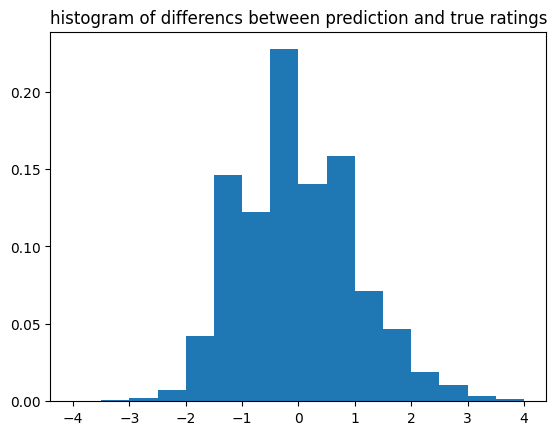

In [54]:
%%time
m = ratings_test_csc.shape[0]
start_ind = 0
for i in np.unique(ratings_test_csc.tocoo().col): # 5k / n_folds loops
    denom = np.zeros((m, 1))
    numer = np.zeros((m, 1))
    baseline_items = ratings_test_csc[:, i].tocoo().row
    n_baseline_items = len(baseline_items)
    for j, sim_score in zip(neigh_ind[i], sim_scores[i]): # n_neighbors loops
        r_v = ratings_train_csc[:, j].toarray()
        mu_v = ratings_train_csc_mean[j]
        w = sim_score * np.minimum(1, r_v)
        denom += w
        numer += w * (r_v - mu_v)
    pred_ratings_for_one_user = (ratings_test_csc_mean[i] + numer / np.maximum(denom, 10 ** (-30)))[baseline_items].flatten()
    ratings_test_csc_predicted.data[start_ind: start_ind + n_baseline_items] = pred_ratings_for_one_user
    start_ind += n_baseline_items
# visualize
rating_diffs = ratings_test_csc_predicted.data - ratings_test_csc.data
n_ratings_test = ratings_test_csc_predicted.data.shape[0]
plt.title("histogram of differencs between prediction and true ratings")
(counts, bins) = np.histogram(rating_diffs, range=(-4, 4), bins=16)
plt.hist(bins[:-1], bins, weights=counts/n_ratings_test)

This plot shows a histogram of difference between our predicted ratings and the true ratings.

We can also take a look at cumulative percentage of ratings being off:

Text(0.5, 1.0, 'Percentage of ratings being within a range (for every 0.5)')

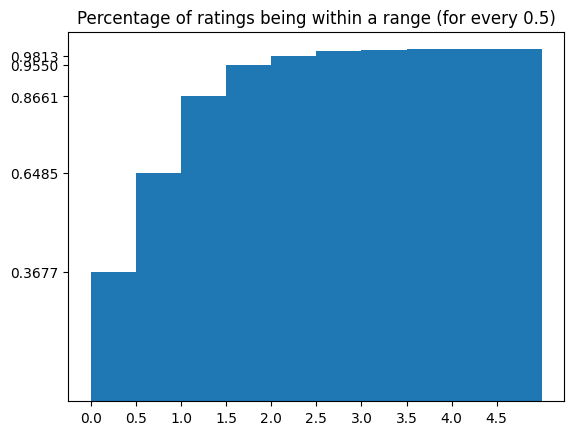

In [70]:
rating_diffs_abs = np.abs(rating_diffs)
(counts, bins) = np.histogram(rating_diffs_abs, range=(0, 5), bins=10)
plt.hist(bins[:-1], bins, weights=counts/n_ratings_test, cumulative=True)
plt.yticks(np.cumsum(counts/n_ratings_test)[:5])
plt.xticks(np.arange(0, 10) / 2)
plt.title("Percentage of ratings being within a range (for every 0.5)")

## 3.4 Collaborative Filtering - Evaluating ratings

TODO: Add evaluation metrics

## 3.5 Collaborative Filtering - Putting all together

TODO: Combine section 3.1-3.4 to a single pipeline.